In [44]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [45]:
aggregated = pd.read_csv('aggregated_savant.csv', index_col = 0)
aggregated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1164 entries, 0 to 1163
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   pitcher                               1164 non-null   int64  
 1   mean_fb_velo                          1164 non-null   float64
 2   mean_fb_spin                          1164 non-null   float64
 3   release_speed                         1164 non-null   float64
 4   release_spin_rate                     1164 non-null   float64
 5   corr_pitch_fb_release_speed           1154 non-null   float64
 6   corr_pitch_fb_release_spin_rate       1155 non-null   float64
 7   corr_pitch_sec_release_speed          1163 non-null   float64
 8   corr_pitch_sec_release_spin_rate      1163 non-null   float64
 9   corr_at_bat_fb_release_speed          1150 non-null   float64
 10  corr_at_bat_fb_release_spin_rate      1151 non-null   float64
 11  corr_at_bat_sec_releas

In [46]:
fangraphs = pd.read_csv('fangraphs_season_level.csv')
fangraphs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3325 entries, 0 to 3324
Columns: 308 entries, PlayerId to Pitching_plus
dtypes: float64(262), int64(41), object(5)
memory usage: 7.8+ MB


In [59]:
labels = pd.read_csv('labels.csv', index_col = 0)
labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 0 to 1258
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   MLBAMID             1259 non-null   int64 
 1   leverage_label      1259 non-null   object
 2   pitcher             1259 non-null   int64 
 3   time_of_game_label  1259 non-null   object
dtypes: int64(2), object(2)
memory usage: 49.2+ KB


In [60]:
fangraphs.loc[:, 'strike_percent'] = fangraphs.loc[:, 'Strikes'] / fangraphs.loc[:, 'Pitches']


In [61]:
wm = lambda x: np.average(x, weights=fangraphs.loc[x.index, "Pitches"])
fangraphs_agg = fangraphs.groupby('MLBAMID').agg(
    strike_percent = ("SwStr_pct", wm),
    total_pitches = ("Pitches", "sum"),
    whip = ("WHIP", wm),
    stuff_plus = ("Stuff_plus", wm)


)

In [62]:
fangraphs_agg.reset_index(inplace = True)

In [67]:
df_pca = (pd.merge(fangraphs_agg, aggregated, left_on = "MLBAMID", right_on = "pitcher").drop(['player_name'], axis = 1).
          merge(labels, how = 'left'))
df_pca.loc[df_pca.loc[:, "role_key"] == "SP", ["time_of_game_label", "leverage_label"]] = "SP"
df_pca_min = df_pca[df_pca.loc[:, 'total_pitches'] > 500].dropna().drop('total_pitches', axis = 1).reset_index(drop = True)

df_pca_min_noid = df_pca_min.drop(['MLBAMID', 'leverage_label', 'pitcher', 'time_of_game_label', 'role_key'], axis = 1)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_pca_min_noid)
pca = PCA(n_components = 2)
pca_output = pca.fit_transform(features_scaled)

df_pc_components = pd.concat([df_pca_min, pd.DataFrame(data = pca_output, columns = ['pc1', 'pc2'])], axis = 1)
df_pc_components.loc[:, "leverage_label_numeric"] = pd.Categorical(df_pc_components.loc[:, 'leverage_label']).codes

In [68]:
loadings = pca.components_.T  # Transpose to align with original features

# Create a DataFrame with the loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=df_pca_min_noid.columns)

print("PCA Loadings:")
print(loadings_df)

PCA Loadings:
                                           PC1       PC2
strike_percent                       -0.181724  0.389493
whip                                  0.070726 -0.350540
stuff_plus                           -0.214996  0.459933
mean_fb_velo                         -0.150511  0.374327
mean_fb_spin                         -0.100909  0.398396
release_speed                        -0.025048  0.068549
release_spin_rate                    -0.074917  0.233129
corr_pitch_fb_release_speed           0.138280  0.029935
corr_pitch_fb_release_spin_rate       0.060625  0.035788
corr_pitch_sec_release_speed          0.092296  0.035832
corr_pitch_sec_release_spin_rate      0.032378  0.030709
corr_at_bat_fb_release_speed         -0.210731  0.048678
corr_at_bat_fb_release_spin_rate     -0.132109 -0.030704
corr_at_bat_sec_release_speed        -0.269727  0.049291
corr_at_bat_sec_release_spin_rate    -0.165293 -0.030140
fb_release_speed_threshold_drop       0.415879  0.183987
fb_release_spin_r

In [69]:
df_pc_components.columns

Index(['MLBAMID', 'strike_percent', 'whip', 'stuff_plus', 'pitcher',
       'mean_fb_velo', 'mean_fb_spin', 'release_speed', 'release_spin_rate',
       'corr_pitch_fb_release_speed', 'corr_pitch_fb_release_spin_rate',
       'corr_pitch_sec_release_speed', 'corr_pitch_sec_release_spin_rate',
       'corr_at_bat_fb_release_speed', 'corr_at_bat_fb_release_spin_rate',
       'corr_at_bat_sec_release_speed', 'corr_at_bat_sec_release_spin_rate',
       'fb_release_speed_threshold_drop',
       'fb_release_spin_rate_threshold_drop',
       'sec_release_speed_threshold_drop',
       'sec_release_spin_rate_threshold_drop', 'role_key', 'leverage_label',
       'time_of_game_label', 'pc1', 'pc2', 'leverage_label_numeric'],
      dtype='object')

In [72]:
X = df_pc_components[['pc1', 'pc2']]
k = 2

kmeans = cluster.KMeans(n_clusters = k).fit(X)
df_pc_components['cluster'] = kmeans.labels_



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


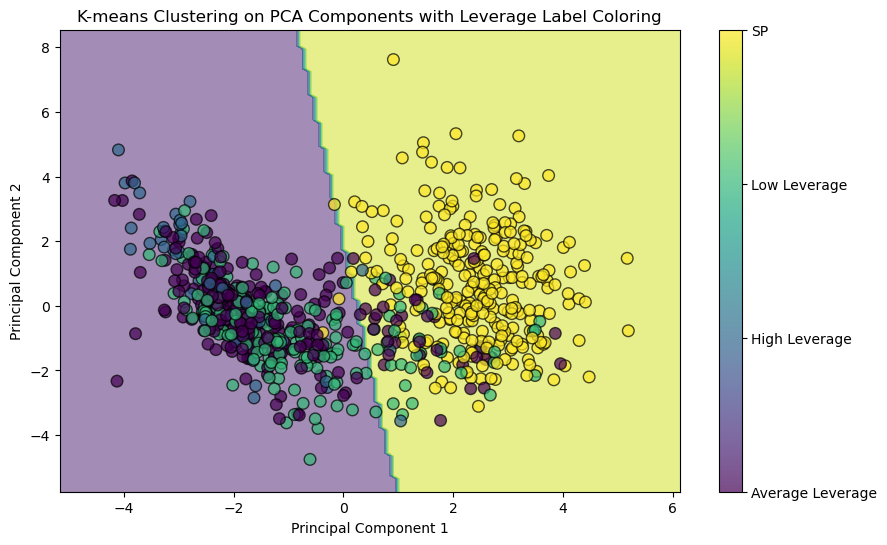

In [73]:
# Step 1: Shade the region of each cluster
# Create a meshgrid for the background colors
x_min, x_max = df_pc_components['pc1'].min() - 1, df_pc_components['pc1'].max() + 1
y_min, y_max = df_pc_components['pc2'].min() - 1, df_pc_components['pc2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Predict cluster for each point in the meshgrid
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the cluster regions
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')

# Step 2: Color each point based on a different label
scatter = plt.scatter(df_pc_components['pc1'], df_pc_components['pc2'], c=df_pc_components['leverage_label_numeric'], edgecolor='k', s=70, alpha=0.7)

cbar = plt.colorbar(scatter)
if df_pc_components['leverage_label'].dtype == 'object':
    # Set tick labels to original categories
    labels = np.unique(df_pc_components['leverage_label'])
    loc = np.arange(len(labels))
    cbar.set_ticks(loc)
    cbar.set_ticklabels(labels)

# Add legend, titles, and labels
plt.title('K-means Clustering on PCA Components with Leverage Label Coloring')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()